**Тема проекта**

Двухагентная система с обучением с подкреплением для стратегических игр (Командир и Советник)

**Цель проекта**

Создать агента на основе алгоритма PPO (Proximal Policy Optimization), который будет обучаться управлять средой (в данном случае, CartPole) с помощью подкрепления. В проекте также есть Советник, который вмешивается в действия агента, когда считает их рискованными, чтобы минимизировать ошибки.  Реализовать систему с оптимальными гиперпараметрами, путем реализацией автоматического побора параметров.

Импортируем необходимые библиотеки

In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt
import optuna
from IPython.display import clear_output
import moviepy.editor as mpy


Напишем универсальную функцию создания среды, что бы была возможность протестировать раздичные среды. 

In [2]:
def create_environment(env_name='CartPole-v1'):
    return gym.make(env_name, render_mode="rgb_array")  

Напишем нашего советника, который вмешивается в работу нашего командира, на основе анализа риска. 

- risk_threshold — это порог риска, при превышении которого Советник вмешивается.
- assess_risk() — функция, которая оценивает риск действия на основе отклонения от среднего значения.
- visualize_intervention() — выводит сообщение, когда Советник вмешивается в действия Командира.


In [3]:
class AdvisorAgent:
    def __init__(self, risk_threshold=0.2):
        self.risk_threshold = risk_threshold

    def assess_risk(self, action, q_values):
        mean_q_value = np.mean(q_values)
        risk = np.abs(action - mean_q_value)
        return risk > self.risk_threshold

    def visualize_intervention(self, action, advised_action, episode, steps):
        print(f"Episode {episode}, Step {steps}: Советник вмешался! "
              f"Командир выбрал {action}, но Советник заменил его на {advised_action}.")


Напишем функцию тренироваки нашего командира, да так. что бы советник мог "направлять" нашего командира, с учетом расков, паралельно будем строить графики обучения, что бы понимать, растет ли наша нашрада и в реальном времени отлеживать ход обучения. Для обучения был выбран алгоритм PPO. 
Советник оценивает действия Командира на каждом шаге, и если действие оказывается слишком рискованным, заменяет его на менее рискованное.

In [6]:
def train_commander_and_advisor(env, advisor, learning_rate, gamma, n_steps, batch_size, clip_range, total_timesteps=10000):
    model = PPO('MlpPolicy', env, verbose=1, learning_rate=learning_rate, gamma=gamma, 
                n_steps=n_steps, batch_size=batch_size, clip_range=clip_range)

    obs, _ = env.reset()  
    reward_history = []
    interventions_per_episode = []
    commander_actions = []
    advisor_interventions = []
    interventions = 0
    rewards_per_episode = []

    plt.ion()
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    for t in range(total_timesteps):
        action, _ = model.predict(obs)
        q_values = action 
        
        if advisor.assess_risk(action, q_values):
            advised_action = env.action_space.sample()  
            advisor.visualize_intervention(action, advised_action, t // env.spec.max_episode_steps, t % env.spec.max_episode_steps)
            interventions += 1
            advisor_interventions.append(advised_action)
        else:
            advised_action = action
            advisor_interventions.append(None)  

        obs, reward, done, _, _ = env.step(advised_action)
        reward_history.append(reward)
        commander_actions.append(advised_action)

        if done:
            rewards_per_episode.append(np.sum(reward_history[-env.spec.max_episode_steps:]))
            interventions_per_episode.append(interventions)

            clear_output(wait=True)
            ax[0].cla()
            ax[1].cla()
            
            ax[0].plot(rewards_per_episode, label='Rewards per Episode')
            ax[0].set_title("Rewards over time")
            ax[0].set_xlabel("Episode")
            ax[0].set_ylabel("Total Reward")

            ax[1].plot(interventions_per_episode, label='Interventions per Episode', color='red')
            ax[1].set_title("Interventions over time")
            ax[1].set_xlabel("Episode")
            ax[1].set_ylabel("Interventions")

            plt.pause(0.01)

            obs, _ = env.reset()  
            interventions = 0

        env.render() 

    plt.ioff()
    plt.show()

    return model, rewards_per_episode, interventions_per_episode, commander_actions, advisor_interventions


Визуализация количества вмешательств Советника по эпизодам

In [7]:
def plot_interventions(interventions_per_episode):
    plt.plot(interventions_per_episode, label='Interventions')
    plt.xlabel('Episode')
    plt.ylabel('Number of Interventions')
    plt.title('Advisor Interventions per Episode')
    plt.legend()
    plt.show()

Визуализация действий Командира и вмешательств Советника

In [8]:
def visualize_commander_and_advisor(commander_actions, advisor_interventions, episodes):
    plt.plot(range(episodes), commander_actions, label='Commander Actions')
    plt.plot(range(episodes), advisor_interventions, label='Advisor Interventions', linestyle='--')
    plt.xlabel('Episode')
    plt.ylabel('Actions')
    plt.title('Commander vs Advisor Actions')
    plt.legend()
    plt.show()

Визуализация наград по эпизодам

In [9]:
def plot_rewards(reward_history):
    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Episodes')
    plt.show()


Визуализация работы обученной модели с Советником и запись видео

In [10]:
def visualize_final_performance_with_advisor(model, advisor, env, episodes=5, video_file="cartpole.mp4"):
    frames = []
    for episode in range(episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        total_reward = 0

        while not done:
            frame = env.render()  
            frames.append(frame) 

            action, _ = model.predict(obs)
            q_values = action
            
            if advisor.assess_risk(action, q_values):
                advised_action = env.action_space.sample()  
                advisor.visualize_intervention(action, advised_action, episode, steps)
            else:
                advised_action = action

            obs, reward, done, _, _ = env.step(advised_action)
            total_reward += reward
            steps += 1
        
        print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    env.close()

    
    clip = mpy.ImageSequenceClip(frames, fps=20)
    clip.write_videofile(video_file)


Для улучшения нашего агента, нам нужно подобрать оптимальные гипер параметры, для этого напишем  функцию для подбора гиперпараметров с помощью Optuna.
Для подбора были выбраны следующие параметры:

- learning_rate - скорость обучения, оптимальное значение обеспечивает баланс между скоростью и точностью обучения. Агент сможет плавно адаптироваться к среде и эффективно улучшать свою политику без чрезмерных колебаний.
- gamma - коэффициент дисконтирования, оптимальное значение помогает агенту сбалансировать краткосрочные и долгосрочные выгоды, что особенно важно для стратегических задач.
- n_steps - число шагов между обновлениями, оптимальное значение обеспечивает баланс между точностью оценок и скоростью обновления политики, что способствует плавному и эффективному обучению.
- batch_size размер мини-пакета - оптимальное значение обеспечивает баланс между стабильностью и скоростью обновлений, позволяя агенту адаптироваться без излишней нестабильности.
- clip_range - граница обрезки - оптимальное значение обеспечивает достаточную свободу для изменений в политике, сохраняя при этом стабильность процесса обучения. Это важно для PPO, который пытается найти баланс между новыми стратегиями и стабильностью.
- risk_threshold - порог риска Советника - оптимальное значение обеспечивает баланс между самостоятельностью агента и вмешательствами Советника. Это помогает снизить риск неправильных действий агента, не подавляя его способность обучаться.

In [11]:
def objective(trial):
    env = create_environment('CartPole-v1')
    advisor = AdvisorAgent(risk_threshold=trial.suggest_uniform('risk_threshold', 0.1, 0.5))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    gamma = trial.suggest_uniform('gamma', 0.9, 0.999)
    n_steps = trial.suggest_int('n_steps', 128, 2048)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.3)

    model, rewards, interventions, commander_actions, advisor_interventions = train_commander_and_advisor(
        env, advisor, learning_rate=learning_rate, gamma=gamma, 
        n_steps=n_steps, batch_size=batch_size, clip_range=clip_range, total_timesteps=10000)

    mean_reward = np.mean(rewards[-100:])
    
    return mean_reward

def optimize_hyperparameters():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    print('Лучшие гиперпараметры:', study.best_params)
    return study


Найдем оптимаолтные гипер параметры.

In [12]:
study = optimize_hyperparameters()

[I 2024-10-01 23:06:41,557] Trial 19 finished with value: 500.0 and parameters: {'risk_threshold': 0.24522630842808463, 'learning_rate': 0.00010920604711003599, 'gamma': 0.9403836010128005, 'n_steps': 1197, 'batch_size': 128, 'clip_range': 0.18056490769825806}. Best is trial 0 with value: 500.0.


Лучшие гиперпараметры: {'risk_threshold': 0.4396786142461876, 'learning_rate': 0.0014253272975443937, 'gamma': 0.9053547445579984, 'n_steps': 741, 'batch_size': 128, 'clip_range': 0.2662448667838019}


Обучение Командира с лучшими гиперпараметрами и вмешательством Советника.

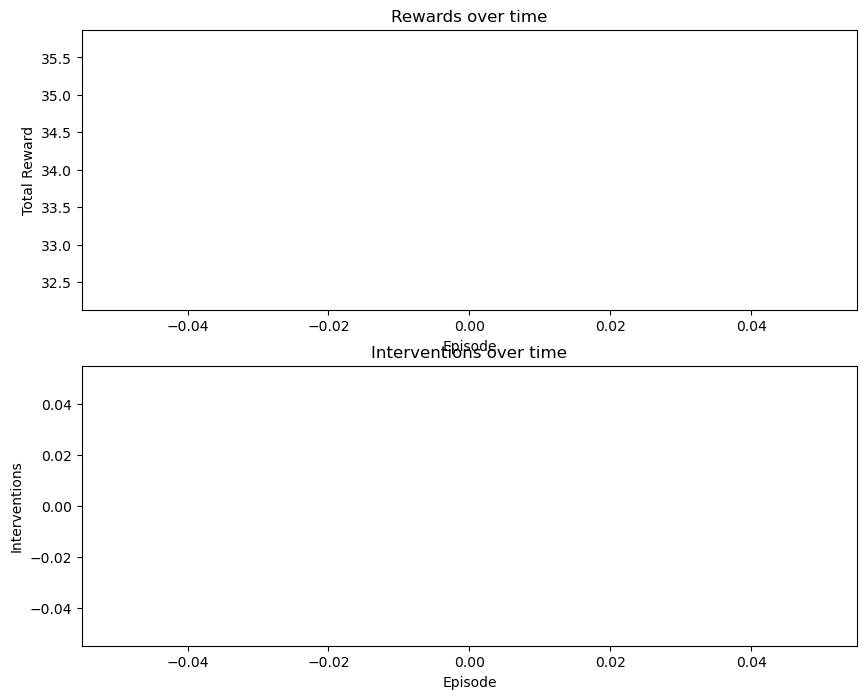

In [13]:
best_params = study.best_params
env = create_environment('CartPole-v1')
advisor = AdvisorAgent(risk_threshold=best_params['risk_threshold'])
    
model, rewards, interventions, commander_actions, advisor_interventions = train_commander_and_advisor(
        env, advisor, learning_rate=best_params['learning_rate'], 
        gamma=best_params['gamma'], n_steps=best_params['n_steps'], 
        batch_size=best_params['batch_size'], clip_range=best_params['clip_range'], 
        total_timesteps=50000)

Построим графики. 

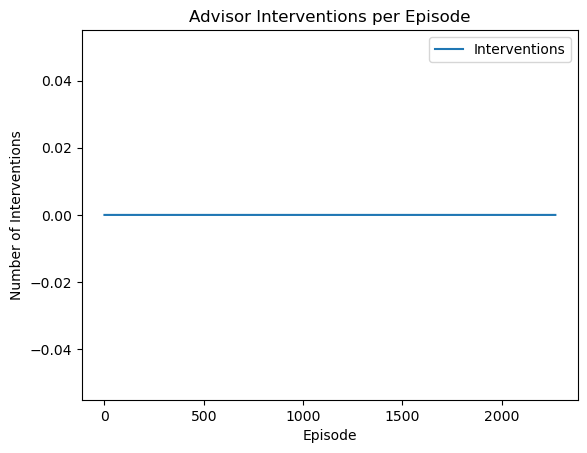

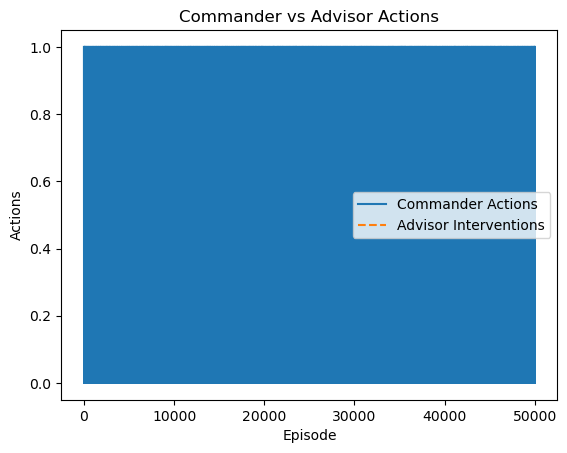

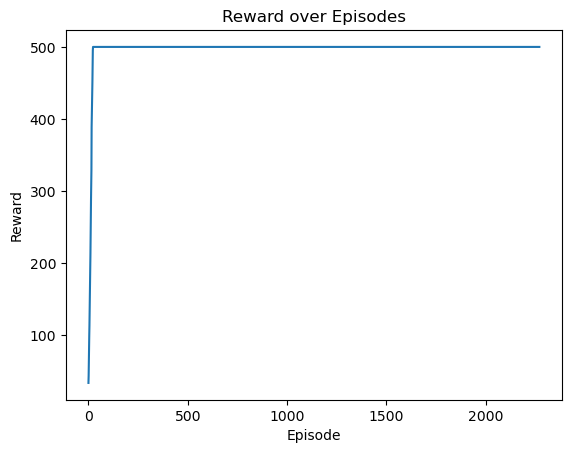

In [14]:
plot_interventions(interventions)
visualize_commander_and_advisor(commander_actions, advisor_interventions, len(commander_actions))
plot_rewards(rewards)

Создадим видеоролик с работой нашей системы. 

In [15]:
visualize_final_performance_with_advisor(model, advisor, env, episodes=5, video_file="final_cartpole.mp4")

Episode 1: Total Reward: 34.0
Episode 2: Total Reward: 16.0
Episode 3: Total Reward: 28.0
Episode 4: Total Reward: 33.0
Episode 5: Total Reward: 31.0
Moviepy - Building video final_cartpole.mp4.
Moviepy - Writing video final_cartpole.mp4



Moviepy - Done !
Moviepy - video ready final_cartpole.mp4


**Вывод.**

Проект состоит из нескольких модулей: создание среды, обучение агента с участием Советника, подбор гиперпараметров и визуализация результатов. Основная цель — продемонстрировать, как можно улучшить обучение агента с помощью вмешательств Советника и подбора оптимальных гиперпараметров.

Для нормально работы агента и системы в целом, необходимо произвести дополнительные опыты с больших количествои эпох, что бы система была обучена и могла показать хороший результат, но в моих условиях реализации сделать это не позволяется возможным. Но основные принципы реализации мультиагентнах систем мною изучено.